In [9]:
import nibabel as nib
import numpy as np
import scipy
import scipy.io as sio
import scipy.stats as scp

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import os.path as op
import time
import urllib.request
from tqdm import tqdm # progress bars

## Read test subject data: GLMsingle results and design files

In [10]:
base_folder = op.join('D:\\', 'Zsuzsa', 'HCCCL', 'miniTRK', 'Results')
mri_folder = op.join(base_folder, '01_MRI', 'fMRI_Preproc', 'VER3', 'aligned')
design_folder = op.join(base_folder, '02_APS_MRI_Logs', 'single_trials')
subj = '760384'
task = 'OBJ'
acq = 'ENC'

In [11]:
# create a directory for saving GLMsingle outputs
outputdir_glmsingle = op.join(base_folder,'01_MRI','fMRI_RSA','GLMsingle', subj, task + '_' + acq)

stimdur = 3.0
tr = 1.84
start_time = time.time()

if op.exists(outputdir_glmsingle):

    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(op.join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(op.join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(op.join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(op.join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()
    
else:
    print('GLMsingle directory does not exist')

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

loading existing GLMsingle outputs from directory:
	D:\Zsuzsa\HCCCL\miniTRK\Results\01_MRI\fMRI_RSA\GLMsingle\760384\OBJ_ENC
	elapsed time:  00:00:22


In [4]:
# load runs and design files
designs = []
for r in ['1','2']:
    design_file =  subj + '_' + task + '_SingleTrials_run_' + r + '.csv' 
    fname = op.join(design_folder, design_file)
    design = pd.read_csv(fname).to_numpy()
    designs.append(design)

In [5]:
# consolidate design matrices
designALL = np.concatenate(designs,axis=0)

# construct a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)

# in order to compute split-half reliability, we have to do some indexing.
# we want to find images with least two repetitions and then prepare a
# useful matrix of indices that refer to when these occur.

repindices = [] # 2 x images containing stimulus trial indices.

# the first row refers to the first presentation; the second row refers to
# the second presentation.
for p in range(designALL.shape[1]): # loop over every condition
    
    temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown in the condition order
    
    # note that for conditions with 3 presentations, we are simply ignoring the third trial
    if len(temp) >= 2:
        repindices.append([temp[0], temp[1]]) 

repindices = np.vstack(np.array(repindices)).T 

In [6]:
op.exists('./vox_reliabilities.npy')

False

In [7]:
# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['fithrf'] = results_glmsingle['typeb']['betasmd'].reshape(136,136,80,152)
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd'].reshape(136,136,80,152)
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd'].reshape(136,136,80,152)

# finally, let's compute split-half reliability. we are going to loop
# through our 4 models and calculate split-half reliability for each of them

if not op.exists('./vox_reliabilities.npy'):

    vox_reliabilities = [] # output variable for reliability values

    modelnames = list(models.keys())

    # for each beta version...
    for m in range(len(modelnames)):

        print(f'computing reliability for beta version: {modelnames[m]}')
        time.sleep(1)

        # get the repeated-condition GLM betas using our repindices variable
        betas = models[modelnames[m]][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
        x,y,z = betas.shape[:3] 

        rels = np.full((x,y,z),np.nan)

        # loop through voxels in the 3D volume...
        for xx in tqdm(range(x)):
            for yy in range(y):
                for zz in range(z):

                    # reliability at a given voxel is pearson correlation between response profiles from first and 
                    # second image presentations (dim = 25 repeated conditions)
                    rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                                 betas[xx,yy,zz,1])[1,0]

        vox_reliabilities.append(rels)

    vox_reliabilities = np.array(vox_reliabilities)
    np.save('vox_reliabilities.npy', vox_reliabilities)

else:
    vox_reliabilities = np.load('vox_reliabilities.npy')

computing reliability for beta version: fithrf


100%|██████████| 136/136 [01:32<00:00,  1.47it/s]


computing reliability for beta version: fithrf_glmdenoise


 38%|███▊      | 52/136 [00:35<00:57,  1.45it/s]


KeyboardInterrupt: 

In [8]:
images = [str(j+1) + k for j in range(181) for k in 'abc']
lureindices = [] # 2 x images containing stimulus trial indices.
lures = []

# the first row refers to the first presentation; the second row refers to
# the second presentation.
for i, im in enumerate(images): # loop over every condition
    temp = []
    
    temp = np.argwhere(corder==i)[:,0] # find indices where this condition was shown
    
    if len(temp) == 1: # check if this exact image was shown only once (otherwise it's a repeat)
        image_version = im[-1]
               
        lureindices.append(temp[0])
        lures.append(im)

lureindices = np.array(lureindices).reshape(48,2).T
lures = np.array(lures).reshape(48,2).T

### Read mask images

In [199]:
# read CA3DG mask image

mask_folder = op.join(base_folder, '01_MRI', 'ANTS_REG', 'ROIS', subj)
mask_file = 'C-mask_' + subj + '_right_CA3DG-To-meanFunc.nii.gz'
fname = op.join(mask_folder, mask_file)
img = nib.load(fname)
roi = img.get_fdata()

r_ca3dg = roi.astype(float)

# convert voxels outside ROI to nan for overlay plotting
r_ca3dg[r_ca3dg==0] = np.nan 

# read PRC mask image
mask_file = 'C-mask_' + subj + '_right_PRC-To-meanFunc.nii.gz'
fname = op.join(mask_folder, mask_file)
img = nib.load(fname)
roi = img.get_fdata()

r_prc = roi.astype(float)

# convert voxels outside ROI to nan for overlay plotting
r_prc[r_prc==0] = np.nan 

# read PHC mask image
mask_file = 'C-mask_' + subj + '_right_PHC-To-meanFunc.nii.gz'
fname = op.join(mask_folder, mask_file)
img = nib.load(fname)
roi = img.get_fdata()

r_phc = roi.astype(float)

# convert voxels outside ROI to nan for overlay plotting
r_phc[r_prc==0] = np.nan 

# Beta Similarity Matrices

In [200]:
r_ca3dg_betas_thr = models['fithrf_glmdenoise_rr'][((r_ca3dg==1) & (vox_reliabilities[2] > 0.00)), :].T
r_prc_betas_thr = models['fithrf_glmdenoise_rr'][((r_prc==1) & (vox_reliabilities[2] > 0.00)), :].T
r_phc_betas_thr = models['fithrf_glmdenoise_rr'][((r_phc==1) & (vox_reliabilities[2] > 0.00)), :].T
r_ca3dg_betas = models['fithrf_glmdenoise_rr'][r_ca3dg==1]
r_prc_betas = models['fithrf_glmdenoise_rr'][r_prc==1]
r_phc_betas = models['fithrf_glmdenoise_rr'][r_phc==1]
print(r_ca3dg_betas.shape)
print(r_prc_betas.shape)
print(r_ca3dg_betas_thr.shape)
print(r_prc_betas_thr.shape)

(233, 152)
(734, 152)
(152, 91)
(152, 329)


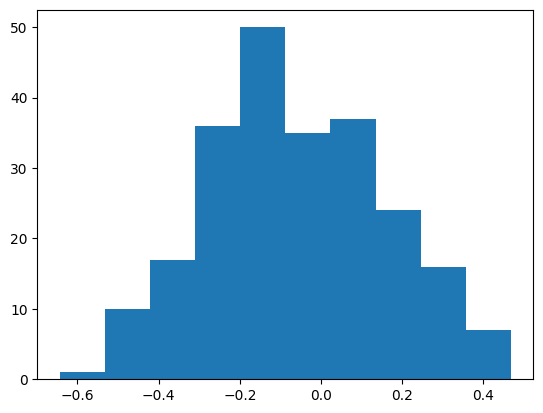

In [201]:
plt.hist(vox_reliabilities[2][r_ca3dg==1]);

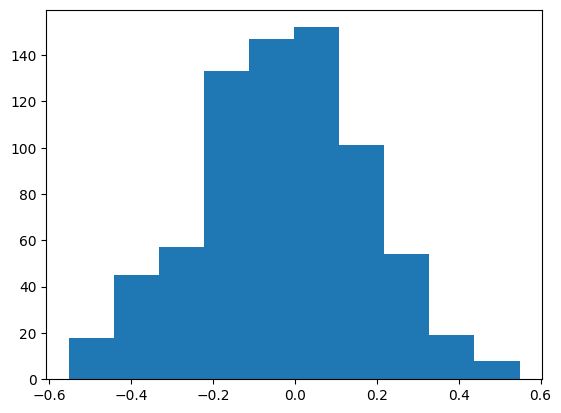

In [202]:
plt.hist(vox_reliabilities[2][r_prc==1]);

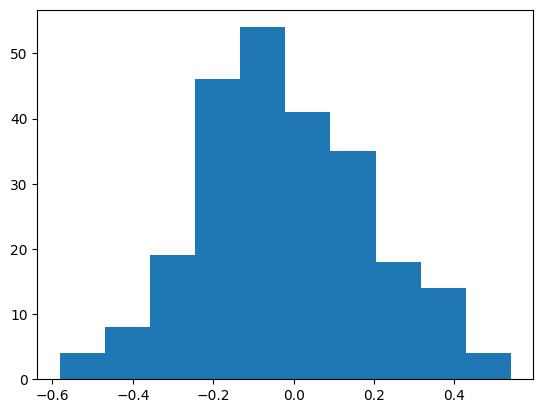

In [203]:
plt.hist(vox_reliabilities[2][r_phc==1]);

In [204]:
r_ca3dg_corr = np.corrcoef(r_ca3dg_betas, rowvar=False)
r_prc_corr = np.corrcoef(r_prc_betas, rowvar=False)
r_phc_corr = np.corrcoef(r_phc_betas, rowvar=False)
print(r_ca3dg_corr.shape)
print(r_prc_corr.shape)
print(r_phc_corr.shape)

(152, 152)
(152, 152)
(152, 152)


In [205]:
r_ca3dg_corr_thr = np.corrcoef(r_ca3dg_betas_thr)
r_prc_corr_thr = np.corrcoef(r_prc_betas_thr)
r_phc_corr_thr = np.corrcoef(r_phc_betas_thr)
print(r_ca3dg_corr_thr.shape)
print(r_prc_corr_thr.shape)
print(r_phc_corr_thr.shape)

(152, 152)
(152, 152)
(152, 152)


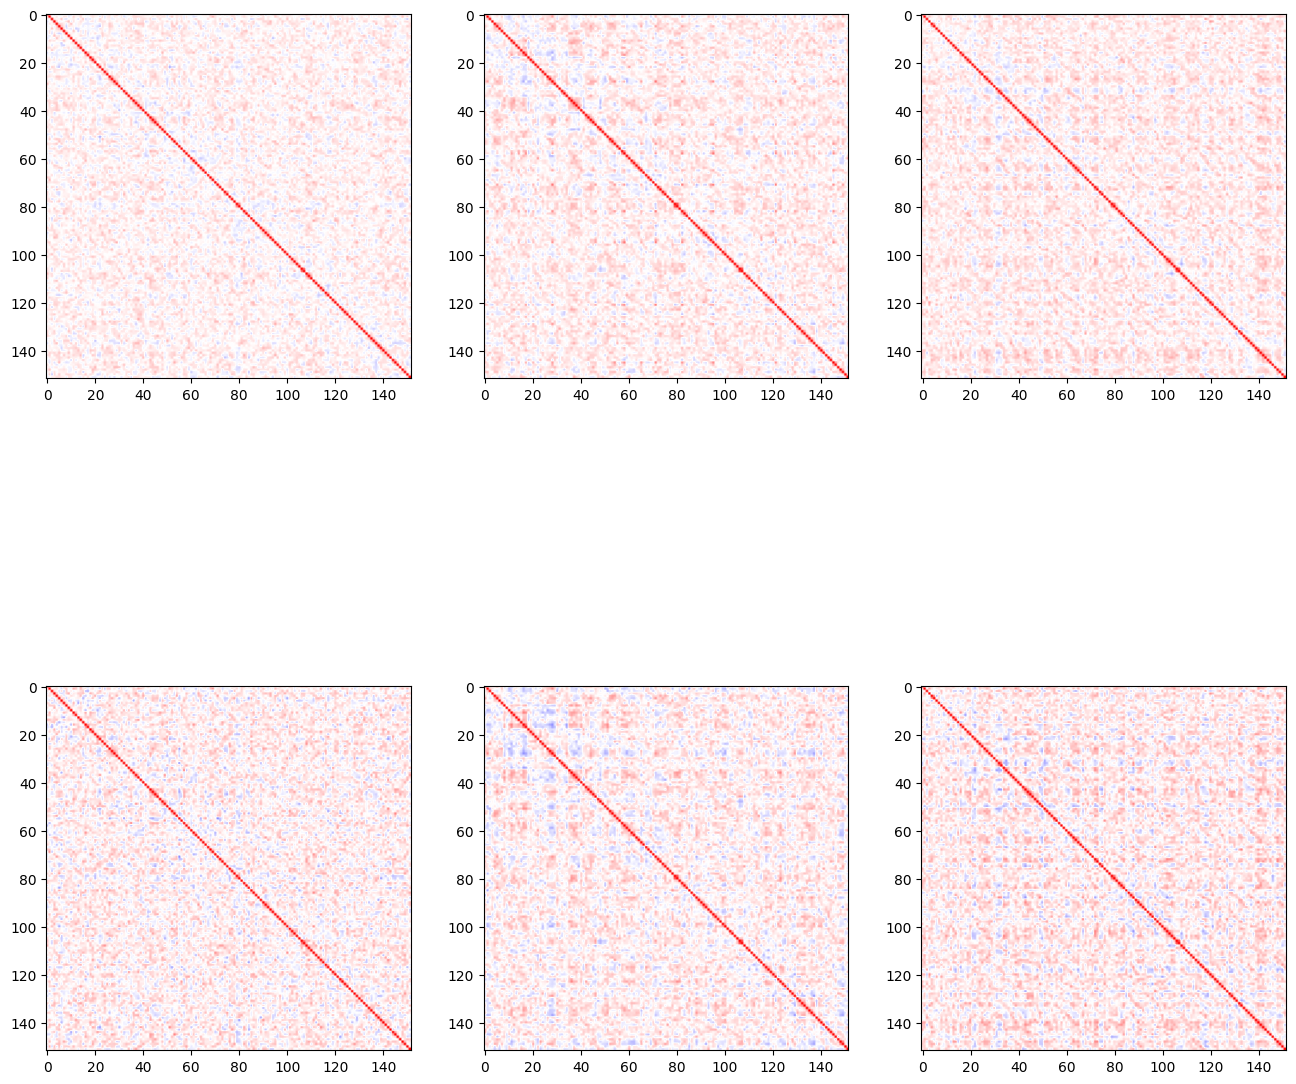

In [206]:
plt.figure(figsize=(16,16))
plt.subplot(231)
plt.imshow(r_ca3dg_corr, vmin=-1, vmax=1, cmap='bwr')
plt.subplot(232)
plt.imshow(r_prc_corr, vmin=-1, vmax=1, cmap='bwr')
plt.subplot(233)
plt.imshow(r_phc_corr, vmin=-1, vmax=1, cmap='bwr')
plt.subplot(234)
plt.imshow(r_ca3dg_corr_thr, vmin=-1, vmax=1, cmap='bwr')
plt.subplot(235)
plt.imshow(r_prc_corr_thr, vmin=-1, vmax=1, cmap='bwr')
plt.subplot(236)
plt.imshow(r_phc_corr_thr, vmin=-1, vmax=1, cmap='bwr')

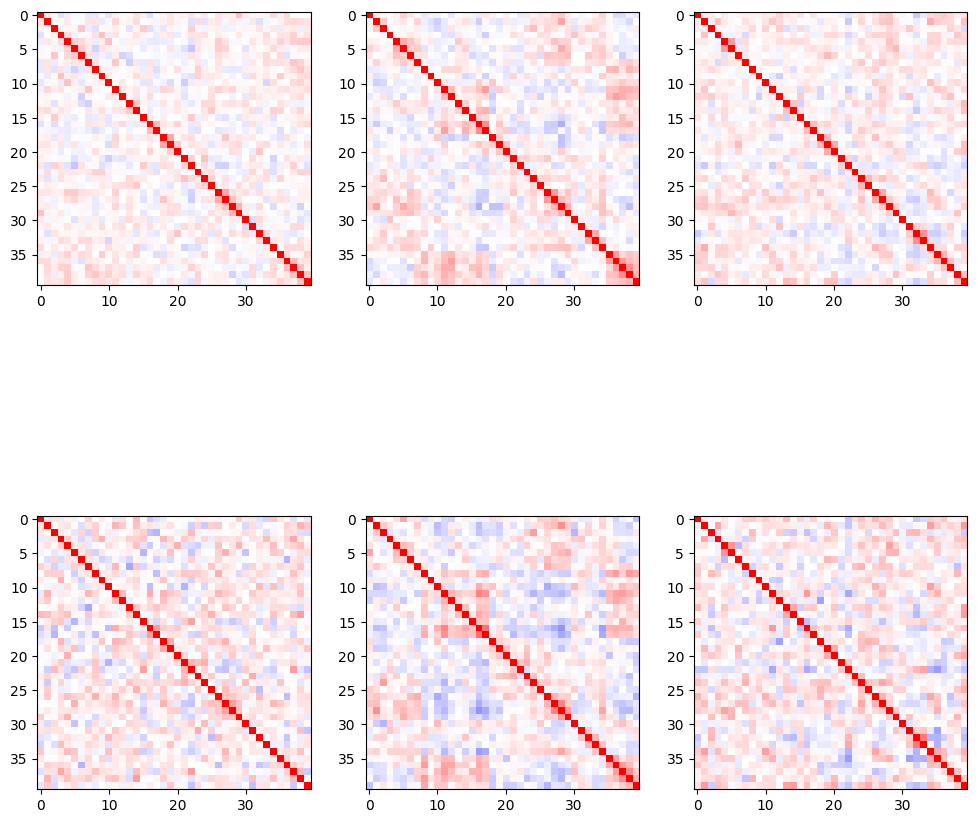

In [209]:
plt.figure(figsize=(12,12))
plt.subplot(231)
plt.imshow(r_ca3dg_corr[:40,:40], vmin=-1, vmax=1, cmap='bwr')
plt.subplot(232)
plt.imshow(r_prc_corr[:40,:40], vmin=-1, vmax=1, cmap='bwr')
plt.subplot(233)
plt.imshow(r_phc_corr[:40,:40], vmin=-1, vmax=1, cmap='bwr')
plt.subplot(234)
plt.imshow(r_ca3dg_corr_thr[:40,:40], vmin=-1, vmax=1, cmap='bwr')
plt.subplot(235)
plt.imshow(r_prc_corr_thr[:40,:40], vmin=-1, vmax=1, cmap='bwr')
plt.subplot(236)
plt.imshow(r_phc_corr_thr[:40,:40], vmin=-1, vmax=1, cmap='bwr')

In [210]:
r_ca3dg_lures = r_ca3dg_corr[lureindices[0], lureindices[1]]
r_prc_lures = r_prc_corr[lureindices[0], lureindices[1]]
r_phc_lures = r_phc_corr[lureindices[0], lureindices[1]]

r_ca3dg_reps = r_ca3dg_corr[repindices[0], repindices[1]]
r_prc_reps = r_prc_corr[repindices[0], repindices[1]]
r_phc_reps = r_phc_corr[repindices[0], repindices[1]]

(0.0, 0.1)

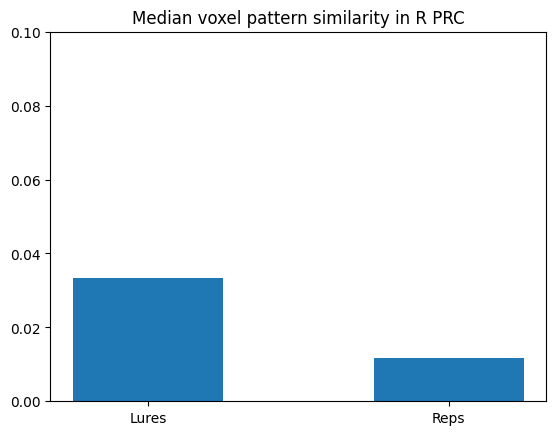

In [189]:
comparison = []
for c in [r_prc_lures, r_prc_reps]:
    comparison.append(np.nanmedian(c))

plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel pattern similarity in R PRC')
plt.xticks(np.arange(len(comparison)),np.array(['Lures', 'Reps']));
plt.ylim([0.0,0.1])

(-0.1, 0.1)

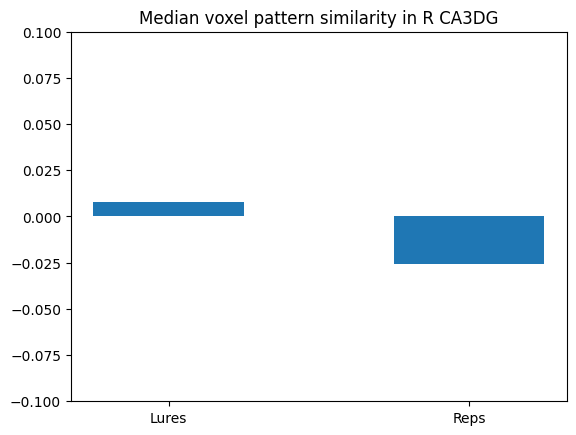

In [190]:
comparison = []
for c in [r_ca3dg_lures, r_ca3dg_reps]:
    comparison.append(np.nanmedian(c))

plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel pattern similarity in R CA3DG')
plt.xticks(np.arange(len(comparison)),np.array(['Lures', 'Reps']));
plt.ylim([-0.1,0.1])

(0.0, 0.1)

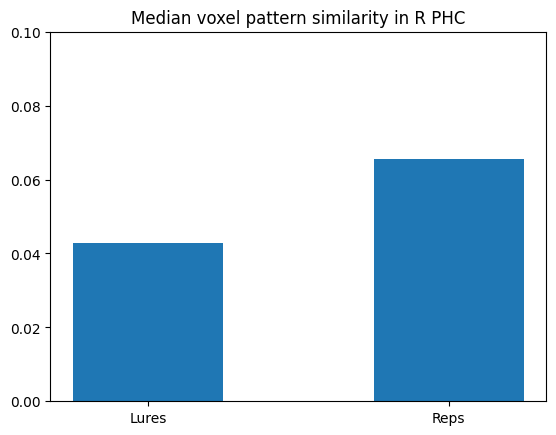

In [213]:
comparison = []
for c in [r_phc_lures, r_phc_reps]:
    comparison.append(np.nanmedian(c))

plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel pattern similarity in R PHC')
plt.xticks(np.arange(len(comparison)),np.array(['Lures', 'Reps']));
plt.ylim([0.0,0.1])

In [214]:
r_ca3dg_lures_thr = r_ca3dg_corr_thr[lureindices[0], lureindices[1]]
r_prc_lures_thr = r_prc_corr_thr[lureindices[0], lureindices[1]]
r_phc_lures_thr = r_phc_corr_thr[lureindices[0], lureindices[1]]

r_ca3dg_reps_thr = r_ca3dg_corr_thr[repindices[0], repindices[1]]
r_prc_reps_thr = r_prc_corr_thr[repindices[0], repindices[1]]
r_phc_reps_thr = r_phc_corr_thr[repindices[0], repindices[1]]

(-0.2, 0.3)

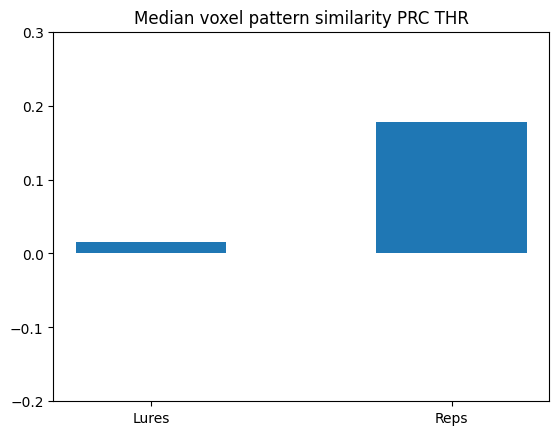

In [215]:
comparison = []
for c in [r_prc_lures_thr, r_prc_reps_thr]:
    comparison.append(np.nanmedian(c))

plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel pattern similarity PRC THR')
plt.xticks(np.arange(len(comparison)),np.array(['Lures', 'Reps']));
plt.ylim([-0.2,0.3])

(-0.2, 0.2)

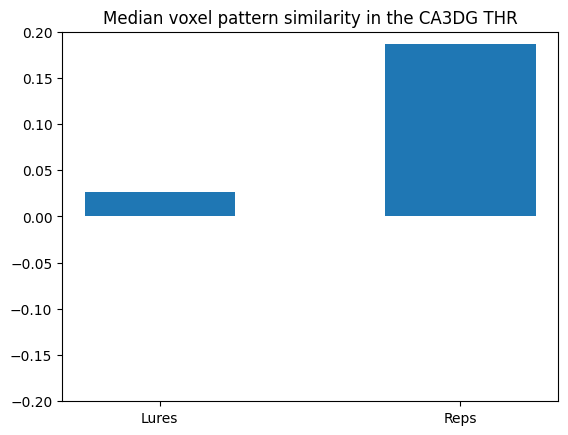

In [216]:
comparison = []
for c in [r_ca3dg_lures_thr, r_ca3dg_reps_thr]:
    comparison.append(np.nanmedian(c))

plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel pattern similarity in the CA3DG THR')
plt.xticks(np.arange(len(comparison)),np.array(['Lures', 'Reps']));
plt.ylim([-0.2,0.2])

(0.0, 0.3)

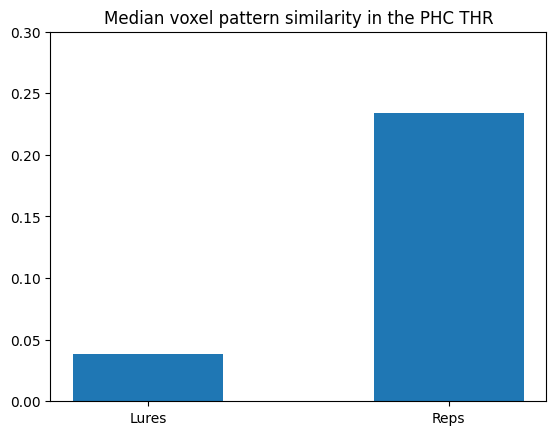

In [217]:
comparison = []
for c in [r_phc_lures_thr, r_phc_reps_thr]:
    comparison.append(np.nanmedian(c))

plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel pattern similarity in the PHC THR')
plt.xticks(np.arange(len(comparison)),np.array(['Lures', 'Reps']));
plt.ylim([0.0,0.3])

# Read similarity data

In [70]:
similarity_path = op.join('..', '..', '..', 'SimilarityRating')
ratings_fname = op.join(similarity_path, 'Results', 'SimilarityRating_MeanScore.csv')
ratings = pd.read_csv(ratings_fname)

In [71]:
print(ratings)

     ImageType abc  MeanScore  ScoreStd       MeanRT        RtStd Rating_Bins
0            1  ab   4.200000  1.619328  2026.700000   554.452092      medium
1            1  ac   3.857143  1.345185  3455.714286  2246.160926      medium
2            1  bc   2.692308  1.974192  2445.153846   952.996052         low
3            2  ab   2.857143  1.951800  4297.428571  2869.358282         low
4            2  ac   4.307692  1.797434  2770.538462   851.615192      medium
..         ...  ..        ...       ...          ...          ...         ...
538        180  ac   5.600000  1.505545  2854.300000   986.631987      medium
539        180  bc   5.923077  1.977437  2107.307692   907.549850      medium
540        181  ab   6.000000  2.000000  2848.307692  1252.883433      medium
541        181  ac   2.900000  1.523884  3194.500000   767.600193         low
542        181  bc   5.428571  1.902379  3332.000000  1803.613041      medium

[543 rows x 7 columns]


In [52]:
lures

array([['8a', '12a', '17a', '25a', '37a', '38a', '40b', '41b', '43b',
        '44a', '47a', '49b', '54a', '59a', '67a', '72a', '79a', '80a',
        '82a', '83a', '86b', '88b', '89a', '90a', '91b', '93b', '97b',
        '98a', '105b', '106a', '109b', '113b', '114a', '119b', '122b',
        '126a', '127a', '130b', '135a', '141a', '144a', '147b', '149a',
        '151a', '156a', '161a', '162a', '163a'],
       ['8c', '12c', '17b', '25b', '37c', '38b', '40c', '41c', '43c',
        '44c', '47c', '49c', '54c', '59b', '67b', '72b', '79c', '80b',
        '82b', '83c', '86c', '88c', '89c', '90b', '91c', '93c', '97c',
        '98c', '105c', '106b', '109c', '113c', '114c', '119c', '122c',
        '126c', '127c', '130c', '135b', '141c', '144c', '147c', '149b',
        '151c', '156b', '161b', '162b', '163b']], dtype='<U4')

In [57]:
ratings['Rating_Bins'].loc[(ratings['ImageType'] == '8') & (ratings['abc'] == 'ac')]

Series([], Name: Rating_Bins, dtype: object)

In [135]:
sim_bins = []

for img1, img2 in zip(lures[0], lures[1]):
    
    img1_type = img1[:-1]
    img1_ver = img1[-1]
    
    img2_type = img2[:-1]
    img2_ver = img2[-1]
    
    if img1_type != img2_type:
        print('Error: types don\'t match')
    
    abc = img1_ver + img2_ver
    #print(img1_type, abc)
    
    sim_bin = ratings['Rating_Bins'].loc[(ratings['ImageType'] == int(img1_type)) & (ratings['abc'] == abc)].reset_index(drop=True)[0]
    
    #print(sim_bin)
    sim_bins.append(sim_bin)
    


In [137]:
target_bins = ['target'] * 25
sim_bins = sim_bins + target_bins

In [142]:
len(sim_bins)

73

In [223]:
data = np.array([np.concatenate((r_ca3dg_lures_thr, r_ca3dg_reps_thr)), 
                 np.concatenate((r_prc_lures_thr, r_prc_reps_thr)), 
                 np.concatenate((r_phc_lures_thr, r_phc_reps_thr)),
                 np.concatenate((r_ca3dg_lures, r_ca3dg_reps)),
                 np.concatenate((r_prc_lures, r_prc_reps)),
                 np.concatenate((r_phc_lures, r_phc_reps))]).T
print(data.shape)
sim_frame = pd.DataFrame(data=data, columns=['R_CA3DG_THR', 'R_PRC_THR', 'R_PHC_THR', 'R_CA3DG', 'R_PRC', 'R_PHC'])
sim_frame['Rating_Bins'] = sim_bins

(73, 6)


C:\Users\Asus\anaconda3\envs\RSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


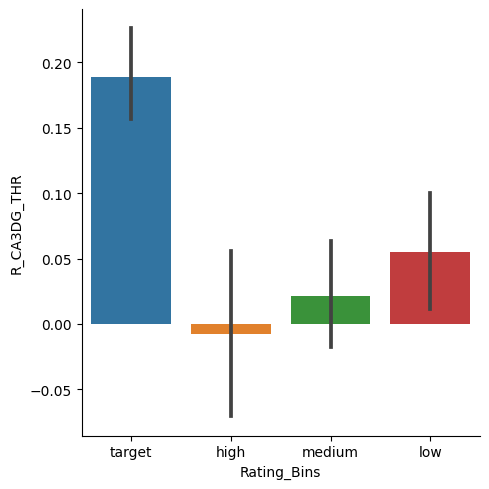

In [224]:
sns.catplot(data=sim_frame, x='Rating_Bins', y='R_CA3DG_THR', order=['target', 'high', 'medium', 'low'], kind='bar')

C:\Users\Asus\anaconda3\envs\RSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


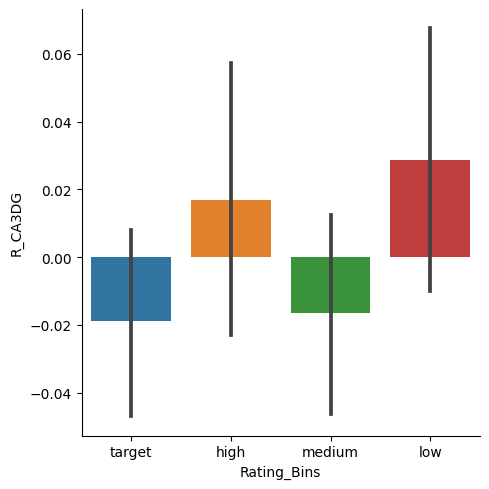

In [225]:
sns.catplot(data=sim_frame, x='Rating_Bins', y='R_CA3DG', order=['target', 'high', 'medium', 'low'], kind='bar')

C:\Users\Asus\anaconda3\envs\RSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


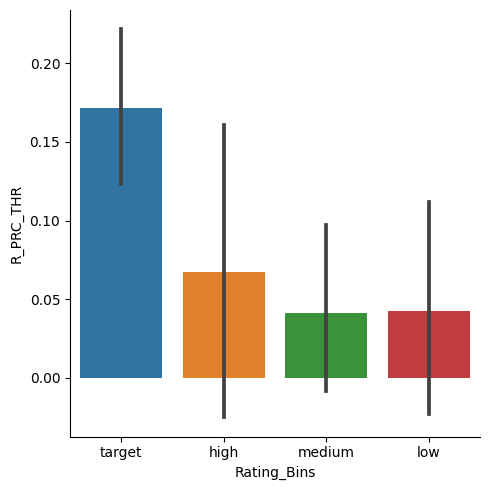

In [226]:
sns.catplot(data=sim_frame, x='Rating_Bins', y='R_PRC_THR', order=['target','high', 'medium', 'low'], kind='bar')

C:\Users\Asus\anaconda3\envs\RSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


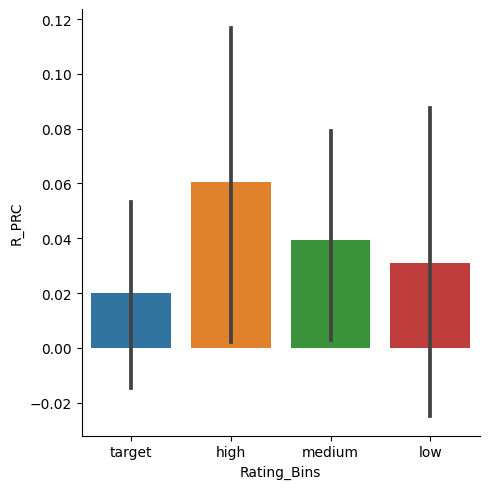

In [227]:
sns.catplot(data=sim_frame, x='Rating_Bins', y='R_PRC', order=['target', 'high', 'medium', 'low'], kind='bar')

C:\Users\Asus\anaconda3\envs\RSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


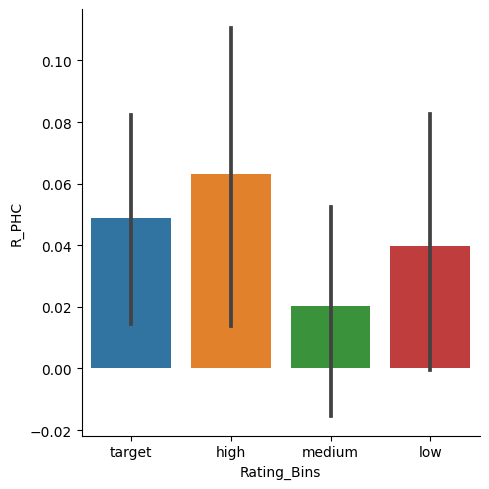

In [228]:
sns.catplot(data=sim_frame, x='Rating_Bins', y='R_PHC', order=['target', 'high', 'medium', 'low'], kind='bar')

C:\Users\Asus\anaconda3\envs\RSA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


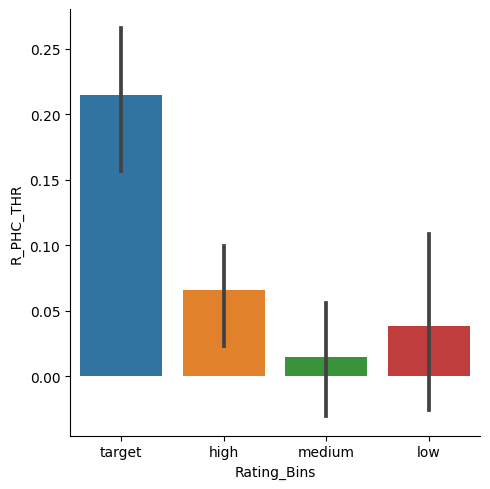

In [229]:
sns.catplot(data=sim_frame, x='Rating_Bins', y='R_PHC_THR', order=['target', 'high', 'medium', 'low'], kind='bar')

## Timing of lures and repetitions

In [158]:
timing1 = []
timing2 = []
for rep in repindices[0]:
    t1 = np.where(designALL[:,corder[rep]]==1)[0][0]
    t2 = np.where(designALL[:,corder[rep]]==1)[0][1]
    timing1.append(t1)
    timing2.append(t2)
timing= np.array([timing1, timing2])

tr_distance_reps = abs(timing[1]-timing[0])
print('mean', np.mean(tr_distance_reps))
print('median',np.median(tr_distance_reps))
print('mode',scp.mode(tr_distance_reps)[0])
print('min',np.min(tr_distance_reps))
print('max',np.max(tr_distance_reps))

mean 14.12
median 14.0
mode 7
min 4
max 45


In [159]:
timing1 = []
timing2 = []
for ind, lure in enumerate(lureindices[0]):
    lure2 = lureindices[1][ind]

    t1 = np.where(designALL[:,corder[lure]]==1)[0][0]
    t2 = np.where(designALL[:,corder[lure2]]==1)[0][0]
    timing1.append(t1)
    timing2.append(t2)
timing= np.array([timing1, timing2])

tr_distance_lures = abs(timing[1]-timing[0])
print('mean', np.mean(tr_distance_lures))
print('median',np.median(tr_distance_lures))
print('mode',scp.mode(tr_distance_lures)[0])
print('min',np.min(tr_distance_lures))
print('max',np.max(tr_distance_lures))

mean 13.125
median 13.5
mode 8
min 5
max 24


In [160]:
scp.ttest_ind(tr_distance_reps, tr_distance_lures)

TtestResult(statistic=0.6327637066417834, pvalue=0.5289206848938203, df=71.0)

# Test subject 2